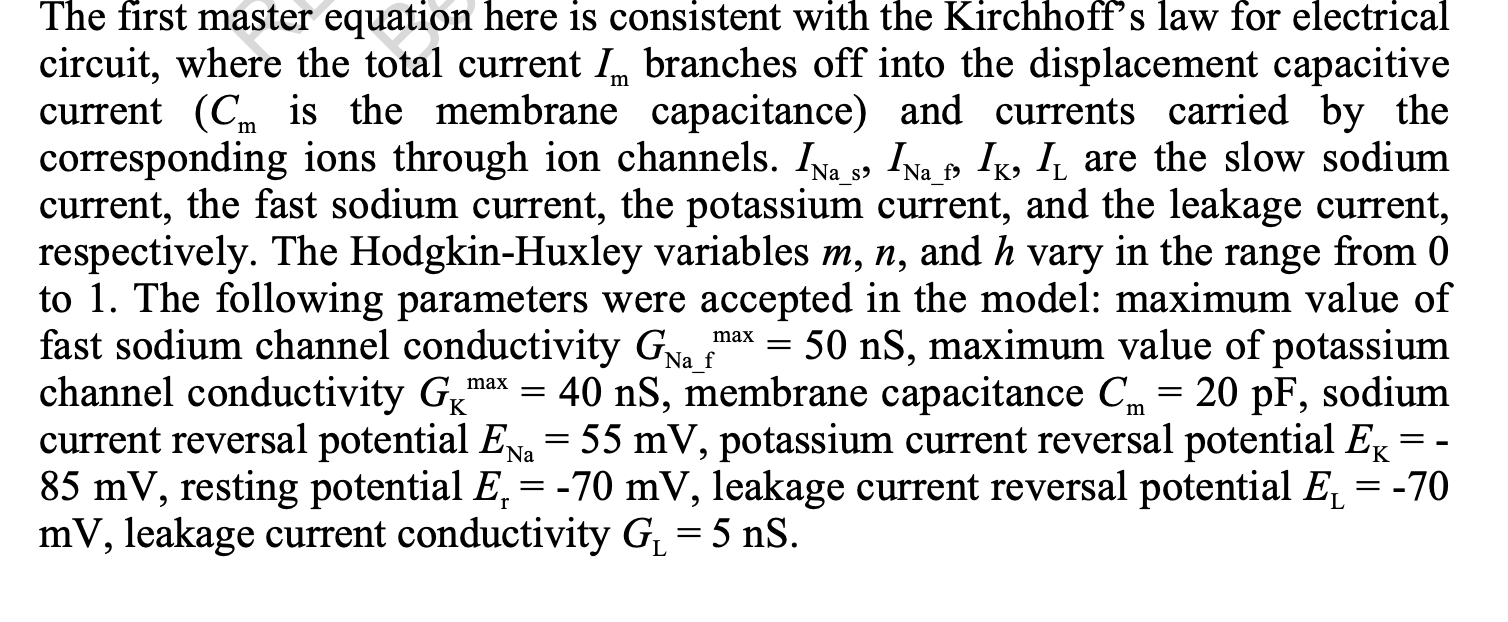

In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

In [26]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

 Нужно запустить спайки при минимальном наборе каналов \
 Натриевый, калиевый каналы, утечка \
 Эти параметры это, конечно, хорошо, но \
 самое главное - это уравнения кинематики для переменных каналов, откуда взять? \
 а, мы будем понемного, по каналу добавлять
- ~утечка~
- ~калиевый ток~
- есть идея сравнить из канал-педии и из примера
- ~Натрий!~
    - ~выбрать базовый~
    - экспериментировать, чтобы получить генерацию спайков
- **Показать, как частота генерации спайков зависит от входящего тока**

\# переделать латех выражения как систему
$$ \alpha_n = 0.032 \frac{(15 - v + v_T)}{exp(\frac{15 - v + v_T}{5}) - 1} $$

$$ \beta_n = 0.5 exp(\frac{10 - v + v_T}{40}) $$

$$ \alpha_m = 0.32 \frac{13 - v + v_T}{exp(\frac{13 - v + v_T}{4}) - 1} $$

$$ \beta_m = 0.28 \frac{v - v_T - 40)}{exp(\frac{v - v_T - 40}{5}) - 1} $$

In [74]:
eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz


I : ampere
"""

neuron = NeuronGroup(1, eqs, method='euler')

stmon = StateMonitor(neuron, ['v'], True)

neuron.v = El

currs = [75, 90, 100, 125, 150, 200]

for i in currs:
    neuron.I = i * pA
    run(180*ms)
    neuron.I = 0 * pA
    run(20*ms)

run(70*ms)

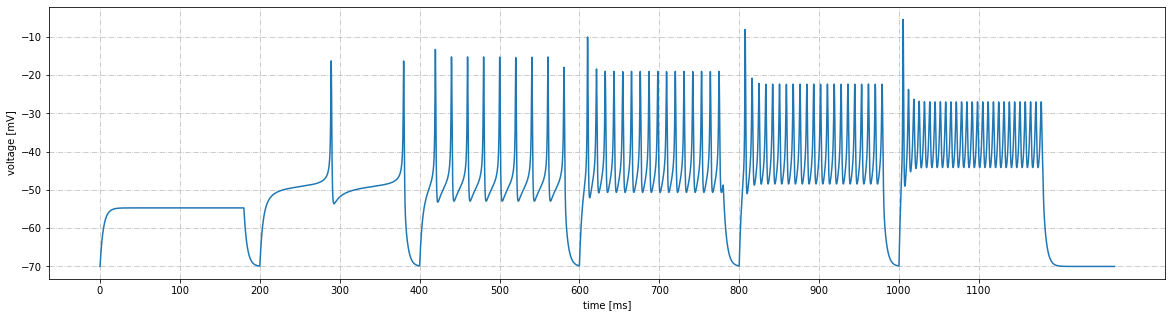

In [75]:
figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV)
ylabel("voltage [mV]")
xlabel("time [ms]")
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')

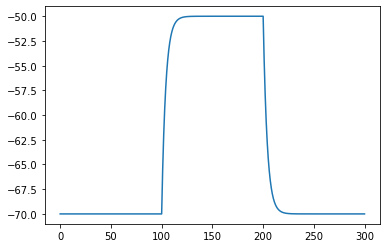

In [22]:
# only leaky
eqs = """
dv/dt = (gL * (El - v) + I) / Cm : volt

I : ampere
"""

neuron = NeuronGroup(1, eqs, method='euler')

stmon = StateMonitor(neuron, ['v'], True)

neuron.v = El

run(100*ms)
neuron.I = 0.1 * nA
run(100*ms)
neuron.I = 0 * nA
run(100*ms)

plot(stmon.t/ms, stmon.v[0]/mV)